# 线性回归从零实现

In [62]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l
import math
import time
import numpy as np

# 2.1 generate dataset

In [63]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [64]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.4221, 0.6441]) 
label: tensor([2.8538])


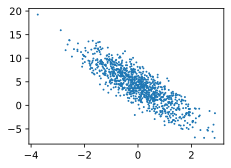

In [65]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

# 2.2 load dataset

In [66]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [67]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.4735,  0.6011],
        [ 1.7446,  0.1509],
        [ 0.0748,  0.4076],
        [-0.0840, -0.9827],
        [-0.5322,  1.2311],
        [-1.2830, -0.4794],
        [-1.3223, -0.2461],
        [ 0.5611,  1.4098],
        [-1.3277,  0.8669],
        [-1.4582,  0.6341]]) 
 tensor([[-0.7970],
        [ 7.1720],
        [ 2.9589],
        [ 7.3604],
        [-1.0397],
        [ 3.2567],
        [ 2.3764],
        [ 0.5381],
        [-1.4062],
        [-0.8618]])


# 2.3 initialize model parameters

In [68]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 2.4 define model

In [69]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

# 2.5 define loss function

In [70]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# 2.6 define optimization algorithm

In [71]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 2.7 train

In [72]:
lr = 0.03
num_epochs = 10
net = linreg
loss = d2l.squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041591
epoch 2, loss 0.000152
epoch 3, loss 0.000049
epoch 4, loss 0.000049
epoch 5, loss 0.000049
epoch 6, loss 0.000049
epoch 7, loss 0.000049
epoch 8, loss 0.000049
epoch 9, loss 0.000049
epoch 10, loss 0.000049


In [73]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002,  0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


# 线性模型的简易实现

In [74]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

# 3.1 generate dataset

In [75]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [76]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [79]:
next(iter(data_iter))

[tensor([[ 1.6206,  1.2082],
         [ 0.7795, -0.0857],
         [-0.9815, -0.3356],
         [ 1.9436,  0.4258],
         [ 1.3463,  0.0627],
         [-0.3063,  0.3326],
         [ 0.1585, -0.4564],
         [ 0.2836,  0.6272],
         [-0.8580,  0.1040],
         [ 0.3734, -1.3940]]),
 tensor([[3.3212],
         [6.0511],
         [3.3826],
         [6.6431],
         [6.6921],
         [2.4504],
         [6.0758],
         [2.6395],
         [2.1011],
         [9.7009]])]

# 3.2 define model

In [80]:
# nn是神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

# 2.3 initialize model parameters

In [82]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

# 2.4 define loss function

In [83]:
loss = nn.MSELoss()

# 2.5 define optimization algorithm

In [84]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 2.6 train

In [85]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000201
epoch 2, loss 0.000101
epoch 3, loss 0.000101


In [86]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0004, -0.0006])
b的估计误差： tensor([-5.7220e-05])
